<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Shor's Algorithm for Integer Factorization*_ 

The latest version of this tutorial notebook is available on https://github.com/qiskit/qiskit-tutorial.

In this tutorial, we first introduce the problem of [integer factorization](#factorization) and describe how [Shor's algorithm](#shorsalgorithm) solves it in detail. We then [implement](#implementation) a version of it in Qiskit.

### Contributors
Anna Phan
***

## Integer Factorization <a id='factorization'></a>

Integer factorization is the decomposition of an composite integer into a product of smaller integers, for example, the integer $100$ can be factored into $10 \times 10$. If these factors are restricted to prime numbers, the process is called prime factorization, for example, the prime factorization of $100$ is $2 \times 2 \times 5 \times 5$. 

When the integers are very large, no efficient classical integer factorization algorithm is known. The hardest factorization problems are semiprime numbers, the product of two prime numbers. In [2009](https://link.springer.com/chapter/10.1007/978-3-642-14623-7_18), a team of researchers factored a 232 decimal digit semiprime number (768 bits), spending the computational equivalent of more than two thousand years on a single core 2.2 GHz AMD Opteron processor with 2 GB RAM:
```
RSA-768  = 12301866845301177551304949583849627207728535695953347921973224521517264005 
           07263657518745202199786469389956474942774063845925192557326303453731548268 
           50791702612214291346167042921431160222124047927473779408066535141959745985 
           6902143413 
           
         = 33478071698956898786044169848212690817704794983713768568912431388982883793 
           878002287614711652531743087737814467999489 
         × 36746043666799590428244633799627952632279158164343087642676032283815739666 
           511279233373417143396810270092798736308917 
```
The presumed difficulty of this semiprime factorization problem underlines many encryption algorithms, such as [RSA](https://www.google.com/patents/US4405829), which is used in online credit card transactions, amongst other applications.
***

## Shor's Algorithm <a id='shorsalgorithm'></a>

Shor's algorithm, named after mathematician Peter Shor, is a polynomial time quantum algorithm for integer factorization formulated in [1994](http://epubs.siam.org/doi/10.1137/S0097539795293172). It is arguably the most dramatic example of how the paradigm of quantum computing changed our perception of which computational problems should be considered tractable, motivating the study of new quantum algorithms and efforts to design and construct quantum computers. It also has expedited research into new cryptosystems not based on integer factorization. 

Shor's algorithm has been experimentally realised by multiple teams for specific composite integers. The composite $15$ was first factored into $3 \times 5$ in [2001](https://www.nature.com/nature/journal/v414/n6866/full/414883a.html) using seven NMR qubits, and has since been implemented using four photon qubits in 2007 by [two](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250504) [teams](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250505), three solid state qubits in [2012](https://www.nature.com/nphys/journal/v8/n10/full/nphys2385.html) and five trapped ion qubits in [2016](http://science.sciencemag.org/content/351/6277/1068). The composite $21$ has also been factored into $3 \times 7$ in [2012](http://www.nature.com/nphoton/journal/v6/n11/full/nphoton.2012.259.html) using a photon qubit and qutrit (a three level system). Note that these experimental demonstrations rely on significant optimisations of Shor's algorithm based on apriori knowledge of the expected results. In general, [$2 + \frac{3}{2}\log_2N$](https://link-springer-com.virtual.anu.edu.au/chapter/10.1007/3-540-49208-9_15) qubits are needed to factor the composite integer $N$, meaning at least $1,154$ qubits would be needed to factor $RSA-768$ above.


In [1]:
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/hOlOY7NyMfs?start=75&end=126",560,315)

As Peter Shor describes in the video above from [PhysicsWorld](http://physicsworld.com/cws/article/multimedia/2015/sep/30/what-is-shors-factoring-algorithm), Shor’s algorithm is composed of three parts. The first part turns the factoring problem into a period finding problem using number theory, which can be computed on a classical computer. The second part  finds the period using the quantum Fourier transform and is responsible for the quantum speedup of the algorithm. The third part uses the period found to calculate the factors.

The following sections go through the algorithm in detail, for those who just want the steps, without the lengthy explanation, refer to the [blue](#stepsone) [boxes](#stepstwo) before jumping down to the [implemention](#implemention). 

### From Factorization to Period Finding

The number theory that underlines Shor's algorithm relates to periodic modulo sequences. Let's have a look at an example of such a sequence. Consider the sequence of the powers of two: 
$$1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, ...$$
Now let's look at the same sequence 'modulo 15', that is, the remainder after fifteen divides each of these powers of two:
$$1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, ...$$
This is a modulo sequence that repeats every four numbers, that is, a periodic modulo sequence with a period of four.

Reduction of factorization of $N$ to the problem of finding the period of an integer $x$ less than $N$ and greater than $1$ depends on the following result from number theory:

> The function $\mathcal{F}(a) = x^a \bmod N$ is a periodic function, where $x$ is an integer coprime to $N$ and $a \ge 0$.

Note that two numbers are coprime, if the only positive integer that divides both of them is 1. This is equivalent to their greatest common divisor being 1. For example, 8 and 15 are coprime, as they don't share any common factors (other than 1). However, 9 and 15 are not coprime, since they are both divisible by 3 (and 1). 

> Since $\mathcal{F}(a)$ is a periodic function, it has some period $r$. Knowing that $x^0 \bmod N = 1$, this means that $x^r \bmod N = 1$ since the function is periodic, and thus $r$ is just the first nonzero power where $x^r = 1 (\bmod N)$.

Given this information and through the following algebraic manipulation: 
$$ x^r \equiv 1 \bmod N $$
$$ x^r = (x^{r/2})^2 \equiv 1 \bmod N $$
$$ (x^{r/2})^2 - 1 \equiv 0 \bmod N $$
and if $r$ is an even number:
$$ (x^{r/2} + 1)(x^{r/2} - 1) \equiv 0 \bmod N $$

From this, the product $(x^{r/2} + 1)(x^{r/2} - 1)$ is an integer multiple of $N$, the number to be factored. Thus, so long as $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is not a multiple of $N$, then at least one of $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ must have a nontrivial factor in common with $N$. 

So computing $\text{gcd}(x^{r/2} - 1, N)$ and $\text{gcd}(x^{r/2} + 1, N)$ will obtain a factor of $N$, where $\text{gcd}$ is the greatest common denominator function, which can be calculated by the polynomial time [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm). 

#### Classical Steps to Shor's Algorithm

Let's assume for a moment that a period finding machine exists that takes as input coprime integers $x, N$ and outputs the period of $x \bmod N$, implemented by as a brute force search below. Let's show how to use the machine to find all prime factors of $N$ using the number theory described above. 

In [2]:
# Brute force period finding algorithm
def find_period_classical(x, N):
    n = 1
    t = x
    while t != 1:
        t *= x
        t %= N
        n += 1
    return n

For simplicity, assume that $N$ has only two distinct prime factors: $N = pq$.

<div class="alert alert-block alert-info"> <a id='stepsone'></a>
<ol>
<li>Pick a random integer $x$ between $1$ and $N$ and compute the greatest common divisor $\text{gcd}(x,N)$ using Euclid's algorithm.</li>
<li>If $x$ and $N$ have some common prime factors, $\text{gcd}(x,N)$ will equal $p$ or $q$. Otherwise $\text{gcd}(x,N) = 1$, meaning $x$ and $N$ are coprime. </li>
<li>Let $r$ be the period of $x \bmod N$ computed by the period finding machine. Repeat the above steps with different random choices of $x$ until $r$ is even.</li>
<li>Now $p$ and $q$ can be found by computing $\text{gcd}(x^{r/2} \pm 1, N)$ as long as $x^{r/2} \neq \pm 1$.</li>
</ol>
</div>

As an example, consider $N = 15$. Let's look at all values of $1 < x < 15$ where $x$ is coprime with $15$:

|  $x$  |         $x^a \bmod 15$       | Period $r$ |$\text{gcd}(x^{r/2}-1,15)$|$\text{gcd}(x^{r/2}+1,15)$ | 
|:-----:|:----------------------------:|:----------:|:------------------------:|:-------------------------:|
|   2   | 1,2,4,8,1,2,4,8,1,2,4...     |      4     |             3            |             5             |
|   4   | 1,4,1,4,1,4,1,4,1,4,1...     |      2     |             3            |             5             |
|   7   | 1,7,4,13,1,7,4,13,1,7,4...   |      4     |             3            |             5             |
|   8   | 1,8,4,2,1,8,4,2,1,8,4...     |      4     |             3            |             5             |
|   11  | 1,11,1,11,1,11,1,11,1,11,1...|      2     |             5            |             3             |
|   13  | 1,13,4,7,1,13,4,7,1,13,4,... |      4     |             3            |             5             |
|   14  | 1,14,1,14,1,14,1,14,1,14,1,,,|      2     |             1            |             15            |

As can be seen, any value of $x$ except $14$ will return the factors of $15$, that is, $3$ and $5$. $14$ is an example of the special case where $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is a multiple of $N$ and thus another $x$ needs to be tried. 

In general, it can be shown that this special case occurs infrequently, so on average only two calls to the period finding machine are sufficient to factor $N$. 

For a more interesting example, first let's find larger number N, that is semiprime that is relatively small. Using the [Sieve of Eratosthenes](https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes) [Python implementation](http://archive.oreilly.com/pub/a/python/excerpt/pythonckbk_chap1/index1.html?page=last), let's generate a list of all the prime numbers less than a thousand, randomly select two, and muliply them.

In [3]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("semiprime N =",N)

semiprime N = 16241


Now implement the [above steps](#stepsone) of Shor's Algorithm:

In [4]:
import math

def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")

semiprime N = 16241, coprime x = 7076, period r = 1998, prime factors = 109 and 149


### Quantum Period Finding <a id='quantumperiodfinding'></a>

Let's first describe the quantum period finding algorithm, and then go through a few of the steps in detail, before going through an example. This algorithm takes two coprime integers, $x$ and $N$, and outputs $r$, the period of $\mathcal{F}(a) = x^a\bmod N$.

<div class="alert alert-block alert-info"><a id='stepstwo'></a>
<ol>
<li> Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. Initialise two registers of qubits, first an argument register with $t$ qubits and second a function register with $n = log_2 N$ qubits. These registers start in the initial state:
$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$ </li>
<li> Apply a Hadamard gate on each of the qubits in the argument register to yield an equally weighted superposition of all integers from $0$ to $T$:
$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle$$ </li>
<li> Implement the modular exponentiation function $x^a \bmod N$ on the function register, giving the state:
$$\vert\psi_2\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle$$
This $\vert\psi_2\rangle$ is highly entangled and exhibits quantum parallism, i.e. the function entangled in parallel all the 0 to $T$ input values with the corresponding values of $x^a \bmod N$, even though the function was only executed once. </li>
<li> Perform a quantum Fourier transform on the argument register, resulting in the state:
$$\vert\psi_3\rangle = \frac{1}{T}\sum_{a=0}^{T-1}\sum_{z=0}^{T-1}e^{(2\pi i)(az/T)}\vert z \rangle \vert x^a \bmod N \rangle$$
where due to the interference, only the terms $\vert z \rangle$ with
$$z = qT/r $$
have significant amplitude where $q$ is a random integer ranging from $0$ to $r-1$ and $r$ is the period of $\mathcal{F}(a) = x^a\bmod N$. </li>
<li> Measure the argument register to obtain classical result $z$. With reasonable probability, the continued fraction approximation of $T / z$ will be an integer multiple of the period $r$. Euclid's algorithm can then be used to find $r$.</li>
</ol>
</div>

Note how quantum parallelism and constructive interference have been used to detect and measure periodicity of the modular exponentiation function.  The fact that interference makes it easier to measure periodicity should not come as a big surprise. After all, physicists routinely use scattering of electromagnetic waves and interference measurements to determine periodicity of physical objects such as crystal lattices. Likewise, Shor's algorithm exploits interference to measure periodicity of arithmetic objects, a computational interferometer of sorts. 

####  Modular Exponentiation

The modular exponentiation, step 3 above, that is the evaluation of $x^a \bmod N$ for $2^t$ values of $a$ in parallel, is the most demanding part of the algorithm. This can be performed using the following identity for the binary representation of any integer: $x = x_{t-1}2^{t-1} + ... x_12^1+x_02^0$, where $x_t$ are the binary digits of $x$. From this, it follows that:

\begin{aligned}
x^a \bmod N & = x^{2^{(t-1)}a_{t-1}} ... x^{2a_1}x^{a_0} \bmod N \\
& = x^{2^{(t-1)}a_{t-1}} ... [x^{2a_1}[x^{2a_0} \bmod N] \bmod N] ... \bmod N \\
\end{aligned}

This means that 1 is first multiplied by $x^1 \bmod N$ if and only if $a_0 = 1$, then the result is multiplied by $x^2 \bmod N$ if and only if $a_1 = 1$ and so forth, until finally the result is multiplied by $x^{2^{(s-1)}}\bmod N$ if and only if $a_{t-1} = 1$. 

Therefore, the modular exponentiation consists of $t$ serial multiplications modulo $N$, each of them controlled by the qubit $a_t$. The values $x,x^2,...,x^{2^{(t-1)}} \bmod N$ can be found efficiently on a classical computer by repeated squaring.

#### Quantum Fourier Transform

The Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT), step 4 above, is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. 

The classical discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula
$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$
with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:
$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

Or the unitary matrix:
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

As an example, we've actually already seen the quantum Fourier transform for when $N = 2$, it is the Hadamard operator ($H$):
$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$
Suppose we have the single qubit state $\alpha \vert 0 \rangle + \beta \vert 1 \rangle$, if we apply the $H$ operator to this state, we obtain the new state:
$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$
Notice how the Hadamard gate performs the discrete Fourier transform for $N = 2$ on the amplitudes of the state. 

So what does the quantum Fourier transform look like for larger N? Let's derive a circuit for $N=2^n$, $QFT_N$ acting on the state $\vert x \rangle = \vert x_1...x_n \rangle$ where $x_1$ is the most significant bit.
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle \:\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 ... y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1...y_k, y/2^n = \sum_{k=1}^n y_k/2^k \\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=0}^n e^{2 \pi i x y_k/2^k } \vert y_1 ... y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials} \\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding} \\
& = \frac{1}{\sqrt{N}} \left(\vert0\rangle + e^{2 \pi i[0.x_n]} \vert1\rangle\right) \otimes...\otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2...x_{n-1}.x_n]} \vert1\rangle\right) \:\text{as}\: e^{2 \pi i x/2^k} = e^{2 \pi i[0.x_k...x_n]} 
\end{aligned}

This is a very useful form of the QFT for $N=2^n$ as only the last qubit depends on the the
values of all the other input qubits and each further bit depends less and less on the input qubits. Furthermore, note that $e^{2 \pi i.0.x_n}$ is either $+1$ or $-1$, which resembles the Hadamard transform.

Before we create the circuit code for general $N=2^n$, let's look at $N=8,n=3$:
$$QFT_8\vert x_1x_2x_3\rangle = \frac{1}{\sqrt{8}} \left(\vert0\rangle + e^{2 \pi i[0.x_3]} \vert1\rangle\right) \otimes \left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right) \otimes  \left(\vert0\rangle + e^{2 \pi i[0.x_1.x_2.x_3]} \vert1\rangle\right) $$

The steps to creating the circuit for $\vert y_1y_2x_3\rangle = QFT_8\vert x_1x_2x_3\rangle$, remembering the [controlled phase rotation gate](../tools/quantum_gates_and_linear_algebra.ipynb
) $CU_1$, would be:
1. Apply a Hadamard to $\vert x_3 \rangle$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i.0.x_3} \vert1\rangle\right) = \frac{1}{\sqrt{2}}\left(\vert0\rangle + (-1)^{x_3} \vert1\rangle\right)$
2. Apply a Hadamard to $\vert x_2 \rangle$, then depending on $k_3$ (before the Hadamard gate) a $CU_1(\frac{\pi}{2})$, giving the state $\frac{1}{\sqrt{2}}\left(\vert0\rangle + e^{2 \pi i[0.x_2.x_3]} \vert1\rangle\right)$.
3. Apply a Hadamard to $\vert x_1 \rangle$, then $CU_1(\frac{\pi}{2})$ depending on $k_2$, and $CU_1(\frac{\pi}{4})$ depending on $k_3$.
4. Measure the bits in reverse order, that is $y_3 = x_1, y_2 = x_2, y_1 = y_3$.

In Qiskit, this is:
```
q3 = QuantumRegister(3, 'q3')
c3 = ClassicalRegister(3, 'c3')

qft3 = QuantumCircuit(q3, c3)
qft3.h(q[0])
qft3.cu1(math.pi/2.0, q3[1], q3[0])
qft3.h(q[1])
qft3.cu1(math.pi/4.0, q3[2], q3[0])
qft3.cu1(math.pi/2.0, q3[2], q3[1])
qft3.h(q[2])
```

For $N=2^n$, this can be generalised, as in the `qft` function in [tools.qi](https://github.com/Q/qiskit-terra/blob/master/qiskit/tools/qi/qi.py):
```
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(math.pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])
```

#### Example

Let's factorize $N = 21$ with coprime $x=2$, following the [above steps](#stepstwo) of the quantum period finding algorithm, which should return $r = 6$. This example follows one from [this](https://arxiv.org/abs/quant-ph/0303175) tutorial. 

1. Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. For $N = 21$, the smallest value of $t$ is 9, meaning $T = 2^t = 512$. Initialise two registers of qubits, first an argument register with $t = 9$ qubits, and second a function register with $n = log_2 N = 5$ qubits: 
$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$

2. Apply a Hadamard gate on each of the qubits in the argument register: 
$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle = \frac{1}{\sqrt{512}}\sum_{a=0}^{511}\vert a \rangle \vert 0 \rangle$$

3. Implement the modular exponentiation function $x^a \bmod N$ on the function register:
\begin{eqnarray}
\vert\psi_2\rangle 
& = & \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle
 = \frac{1}{\sqrt{512}}\sum_{a=0}^{511}\vert a \rangle \vert 2^a \bmod 21 \rangle \\
& = & \frac{1}{\sqrt{512}} \bigg( \;\; \vert 0 \rangle \vert 1 \rangle + \vert 1 \rangle \vert 2 \rangle +
\vert 2 \rangle \vert 4 \rangle + \vert 3 \rangle \vert 8 \rangle + \;\; \vert 4 \rangle \vert 16 \rangle + \;\,
\vert 5 \rangle \vert 11 \rangle \, + \\
& & \;\;\;\;\;\;\;\;\;\;\;\;\;\, \vert 6 \rangle \vert 1 \rangle + \vert 7 \rangle \vert 2 \rangle + \vert 8 \rangle \vert 4 \rangle + \vert 9 \rangle \vert 8 \rangle + \vert 10 \rangle \vert 16 \rangle + \vert 11 \rangle \vert 11 \rangle \, +\\
& & \;\;\;\;\;\;\;\;\;\;\;\;\, \vert 12 \rangle \vert 1 \rangle + \ldots \bigg)\\
\end{eqnarray}
Notice that the above expression has the following pattern: the states of the second register of each “column” are the same. Therefore we can rearrange the terms in order to collect the second register:
\begin{eqnarray}
\vert\psi_2\rangle 
& = & \frac{1}{\sqrt{512}} \bigg[ \big(\,\vert 0 \rangle + \;\vert 6 \rangle + \vert 12 \rangle \ldots + \vert 504 \rangle + \vert 510 \rangle \big) \, \vert 1 \rangle \, + \\
& & \;\;\;\;\;\;\;\;\;\;\; \big(\,\vert 1 \rangle + \;\vert 7 \rangle + \vert 13 \rangle \ldots + \vert 505 \rangle + \vert 511 \rangle \big) \, \vert 2 \rangle \, + \\
& & \;\;\;\;\;\;\;\;\;\;\; \big(\,\vert 2 \rangle + \;\vert 8 \rangle + \vert 14 \rangle \ldots + \vert 506 \rangle +  \big) \, \vert 4 \rangle \, +  \\
& & \;\;\;\;\;\;\;\;\;\;\; \big(\,\vert 3 \rangle + \;\vert 9 \rangle + \vert 15 \rangle \ldots + \vert 507 \rangle +  \big) \, \vert 8 \rangle \, +  \\
& & \;\;\;\;\;\;\;\;\;\;\; \big(\,\vert 4 \rangle + \vert 10 \rangle + \vert 16 \rangle \ldots + \vert 508 \rangle +  \big)  \vert 16 \rangle \, +  \\
& & \;\;\;\;\;\;\;\;\;\;\; \big(\,\vert 5 \rangle + \vert 11 \rangle + \vert 17 \rangle \ldots + \vert 509 \rangle +  \big)  \vert 11 \rangle \, \bigg]\\
\end{eqnarray}

4. To simplify following equations, we'll measure the function register before performing a quantum Fourier transform on the argument register. This will yield one of the following numbers with equal probability: $\{1,2,4,6,8,16,11\}$. Suppose that the result of the measurement was $2$, then:
$$\vert\psi_3\rangle = \frac{1}{\sqrt{86}}(\vert 1 \rangle + \;\vert 7 \rangle + \vert 13 \rangle \ldots + \vert 505 \rangle + \vert 511 \rangle)\, \vert 2 \rangle $$
It does not matter what is the result of the measurement; what matters is the periodic pattern. The period of the states of the first register is the solution to the problem and the quantum Fourier transform can reveal the value of the period.

5. Perform a quantum Fourier transform on the argument register:
$$
\vert\psi_4\rangle
 = QFT(\vert\psi_3\rangle)
 = QFT(\frac{1}{\sqrt{86}}\sum_{a=0}^{85}\vert 6a+1 \rangle)\vert 2 \rangle
 = \frac{1}{\sqrt{512}}\sum_{j=0}^{511}\bigg(\big[ \frac{1}{\sqrt{86}}\sum_{a=0}^{85} e^{-2 \pi i \frac{6ja}{512}} \big] e^{-2\pi i\frac{j}{512}}\vert j \rangle \bigg)\vert 2 \rangle
$$

6. Measure the argument register. The probability of measuring a result $j$ is:
$$ \rm{Probability}(j) = \frac{1}{512 \times 86} \bigg\vert \sum_{a=0}^{85}e^{-2 \pi i \frac{6ja}{512}} \bigg\vert^2$$
This peaks at $j=0,85,171,256,341,427$. Suppose that the result of the measement yielded $j = 85$, then using continued fraction approximation of $\frac{512}{85}$, we obtain $r=6$, as expected. 

## Implementation <a id='implementation'></a>

In [5]:
from qiskit import BasicAer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

As mentioned [earlier](#shorsalgorithm), many of the experimental demonstrations of Shor's algorithm rely on significant optimisations based on apriori knowledge of the expected results. We will follow the formulation in [this](http://science.sciencemag.org/content/351/6277/1068) paper, which demonstrates a reasonably scalable realisation of Shor's algorithm using $N = 15$. Below is the first figure from the paper, showing various quantum circuits, with the following caption: _Diagrams of Shor’s algorithm for factoring $N = 15$, using a generic textbook approach (**A**) compared with Kitaev’s approach (**B**) for a generic base $a$. (**C**) The actual implementation for factoring $15$ to base $11$, optimized for the corresponding single-input state. Here $q_i$ corresponds to the respective qubit in the computational register. (**D**) Kitaev’s approach to Shor’s algorithm for the bases ${2, 7, 8, 13}$. Here, the optimized map of the first multiplier is identical in all four cases, and the last multiplier is implemented with full modular multipliers, as depicted in (**E**). In all cases, the single QFT qubit is used three times, which, together with the four qubits in the computation register, totals seven effective qubits. (**E**) Circuit diagrams of the modular multipliers of the form $a \bmod N$ for bases $a = {2, 7, 8, 11, 13}$._

<img src="images/shoralgorithm.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="center">


Note that we cannot run this version of Shor's algorithm on an IBM Quantum Experience device at the moment as we currently lack the ability to do measurement feedforward and qubit resetting. Thus we'll just be building the ciruits to run on the simulators for now. Based on Pinakin Padalia & Amitabh Yadav's implementation, found [here](https://github.com/amitabhyadav/Shor-Algorithm-on-IBM-Quantum-Experience)

First we'll construct the $a^1 \bmod 15$ circuits for $a = 2,7,8,11,13$ as in **E**:

In [6]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

Next we'll build the rest of the period finding circuit as in **D**:

In [7]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

Next we build the optimised circuit for $11 \bmod 15$ as in **C**.

In [8]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    qc.u1(3.*math.pi/4.,qr[4]).c_if(cr, 3)
    qc.u1(math.pi/2.,qr[4]).c_if(cr, 2)
    qc.u1(math.pi/4.,qr[4]).c_if(cr, 1)
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

Let's build and run a circuit for $a = 7$, and plot the the circuit and results:

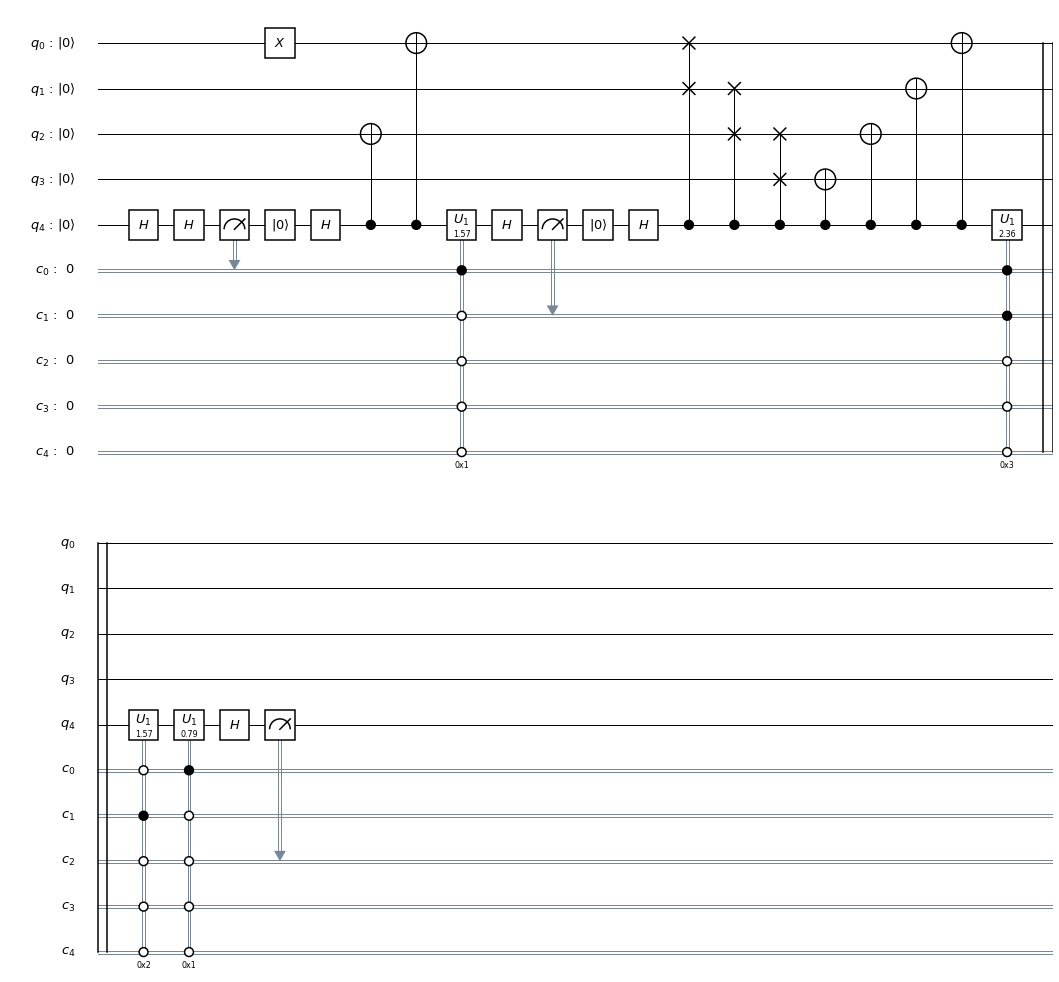

In [9]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')

shor = QuantumCircuit(q, c)
circuit_aperiod15(shor,q,c,7)
shor.draw(output='mpl')

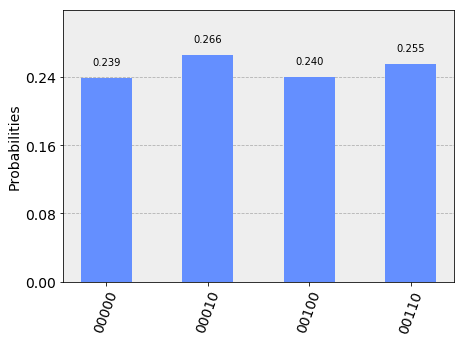

In [10]:
backend = BasicAer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)

We see the measurements yield $x = 0, 2, 4$ and $6$ with equal(ish) probability. Using the continued fraction expansion for $x/2^3$, we note that only $x = 2$ and $6$ give the correct period $r = 4$, and thus the factors $p = \text{gcd}(a^{r/2}+1,15) = 3$ and $q = \text{gcd}(a^{r/2}-1,15) = 5$. 

Why don't you try seeing what you get for $a = 2, 8, 11, 13$?